# Email Spam Classifier

In [2]:
import numpy as np
import pandas as pd
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [4]:
df.shape

(5572, 5)

### Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
# drop last 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
# renaming the columns
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [8]:
# ham - 0 , spam - 1
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])


In [9]:
# check for missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [10]:
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.shape

(5169, 2)

### Exploratory Data Analysis

In [11]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

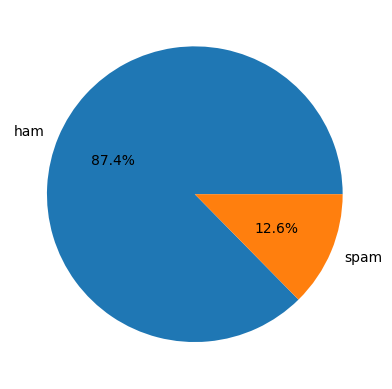

In [12]:
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct='%0.1f%%')
plt.show()

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\daksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# adding a column for number of characters
df['num_characters'] = df['text'].apply(len)

In [15]:
# adding a column for number of words
tokenizer = TreebankWordTokenizer()
df['num_words'] = df['text'].apply(lambda word: len(tokenizer.tokenize(word)))

In [16]:
# adding a column for number of sentences
df['num_sentences'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

In [17]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,17.695299,1.965564
std,58.236293,12.672457,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,14.000000,1.000000
75%,117.000000,25.000000,2.000000
max,910.000000,214.000000,38.000000


In [18]:
# ham messages
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.452613,1.820195
std,56.358207,12.858450,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,21.000000,2.000000
max,910.000000,214.000000,38.000000


In [19]:
# spam messages
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,26.289433,2.970904
std,30.137753,6.579189,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,24.000000,2.000000
50%,149.000000,28.000000,3.000000
75%,157.000000,30.000000,4.000000
max,224.000000,41.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

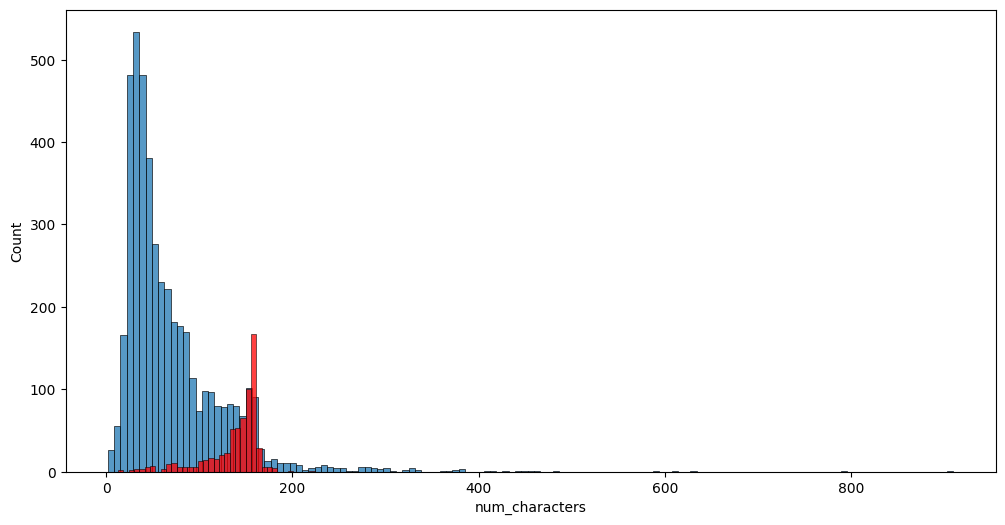

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

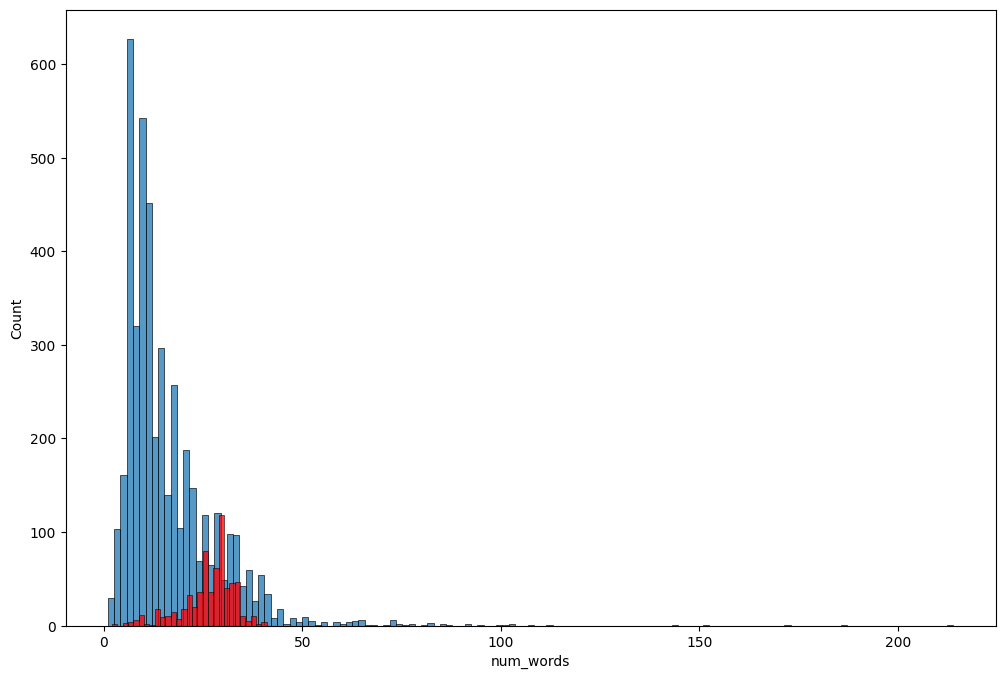

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

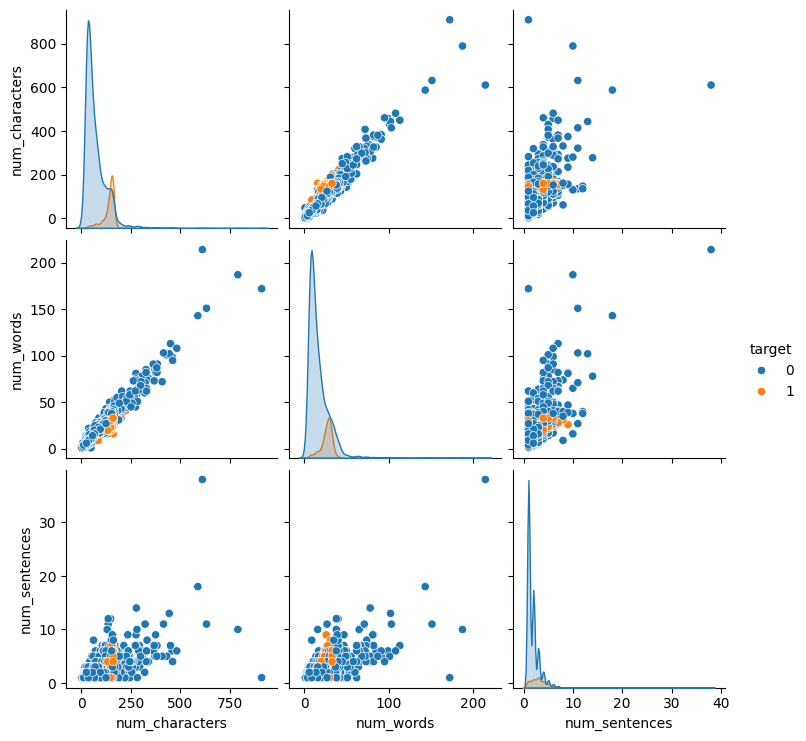

In [22]:
sns.pairplot(df,hue='target')

<Axes: >

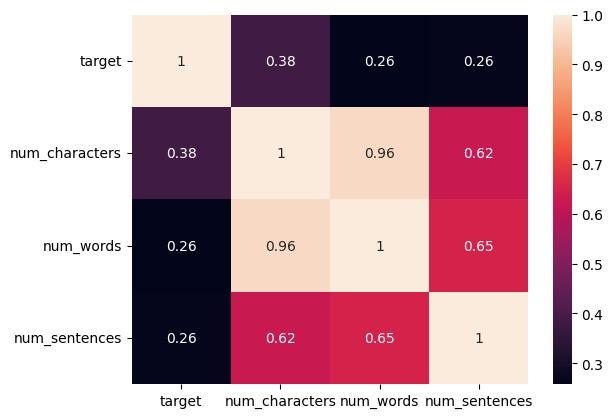

In [23]:
sns.heatmap(df[['target', 'num_characters', 'num_words', 'num_sentences']].corr(),annot=True)

### Data Preprocessing

In [24]:
''' 
    1) Lower Case
    2) Tokenization
    3) Removing Special Characters
    4) Removing stop words and punctuation
    5) Stemming
'''
ps = PorterStemmer()
def transform_text(text):
    # 1) Lower Case
    text = text.lower()

    # 2) Tokenization
    text = nltk.word_tokenize(text)

    # 3) Removing Special Characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    
    # 4) Removing stop words and punctutations
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    
    text = y[:]
    return " ".join(y)


In [25]:
test_text = "Hello World! This is a TEST message... With 123 numbers & special @#$ characters. I am Programmer who is dancing"
transformed_text = transform_text(test_text)
print("Original text:", test_text)
print("Transformed text:", transformed_text)

Original text: Hello World! This is a TEST message... With 123 numbers & special @#$ characters. I am Programmer who is dancing
Transformed text: hello world test messag 123 number special charact programm danc


In [26]:
df['transformed_text'] = df['text'].apply(transform_text)

In [27]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,36,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


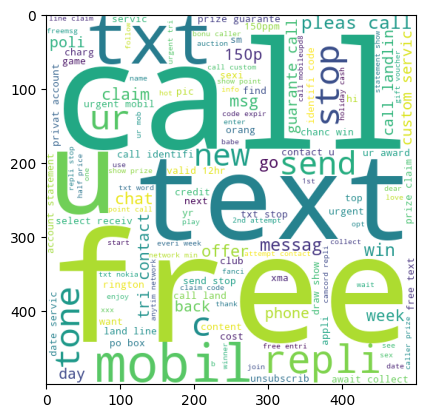

In [28]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

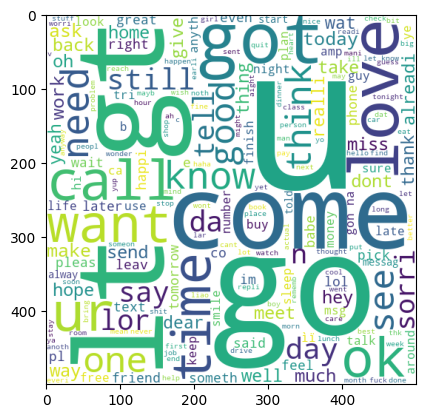

In [29]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

In [30]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
len(spam_corpus)

9939

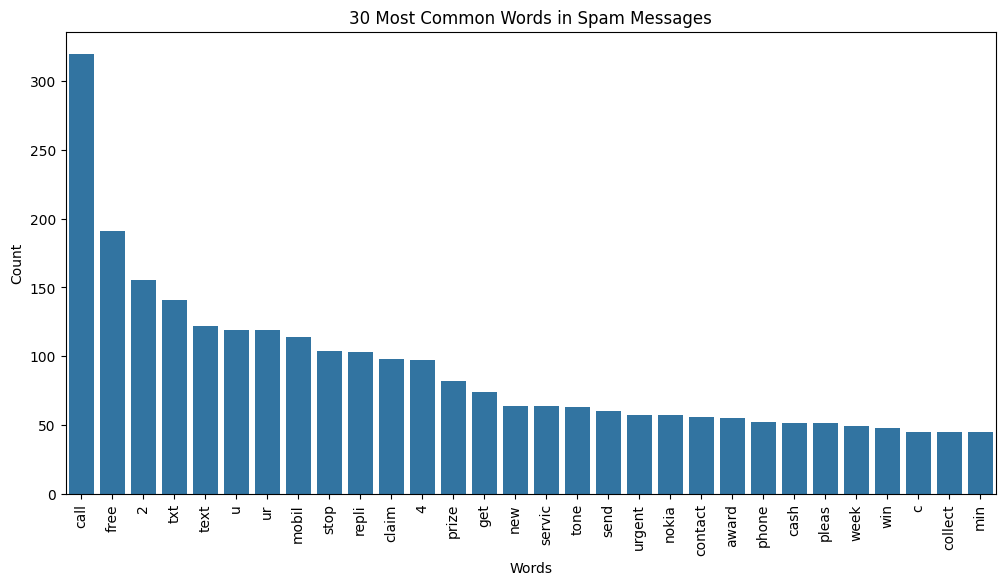

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.title('30 Most Common Words in Spam Messages')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

In [32]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
len(ham_corpus)

35404

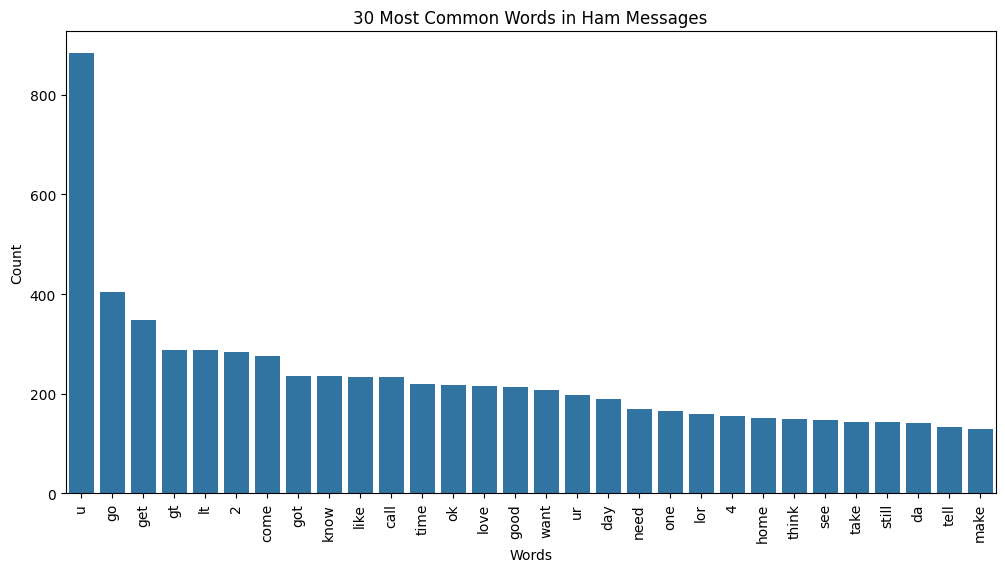

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.title('30 Most Common Words in Ham Messages')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

### Model Building

In [34]:
# Text vectorization using Bag of Words
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [35]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
X.shape

(5169, 3000)

In [36]:
y = df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2)

In [38]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [39]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.874274661508704
[[790 106]
 [ 24 114]]
0.5181818181818182


In [40]:
# we are going with this as the precision is really good, even though accuracy is not but it is not realiable
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [41]:
# best of all 
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [44]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [45]:
# all algos in a dictionary 
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [46]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [47]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT
Accuracy -  0.9323017408123792
Precision -  0.8333333333333334
For  LR
Accuracy -  0.9555125725338491
Precision -  0.96
For  RF
Accuracy -  0.9738878143133463
Precision -  0.9826086956521739
For  AdaBoost
Accuracy -  0.9216634429400387
Precision -  0.8202247191011236
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8682170542635659
For  ETC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  GBDT
Accuracy -  0.9506769825918762
Precision -  0.9306930693069307
For  xgb
Accuracy -  0.9680851063829787
Precision -  0.9487179487179487


In [48]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.973888,0.982609
0,SVC,0.975822,0.974790
8,ETC,0.974855,0.974576
4,LR,0.955513,0.960000
10,xgb,0.968085,0.948718
9,GBDT,0.950677,0.930693
7,BgC,0.958414,0.868217
3,DT,0.932302,0.833333


In [49]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.905222
1,NB,Accuracy,0.970986
2,RF,Accuracy,0.973888
3,SVC,Accuracy,0.975822
4,ETC,Accuracy,0.974855
5,LR,Accuracy,0.955513
6,xgb,Accuracy,0.968085
7,GBDT,Accuracy,0.950677
8,BgC,Accuracy,0.958414
9,DT,Accuracy,0.932302


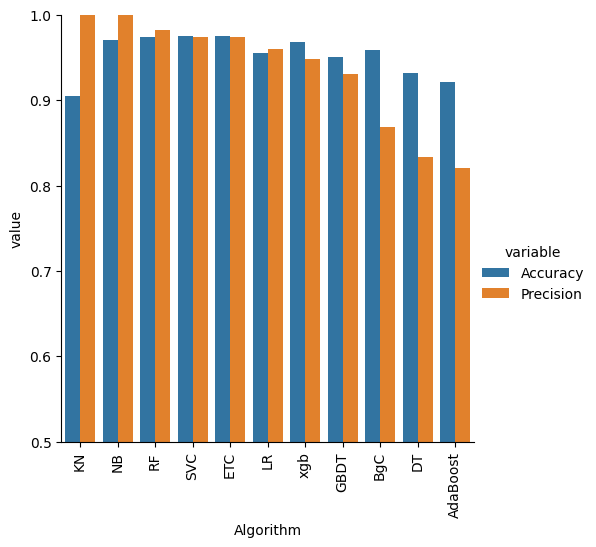

In [50]:
sns.catplot(x = 'Algorithm', y='value', hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

### Improving Model

In [51]:
# 1) Change the max_features parameter of TfIdf
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [52]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [53]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [54]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')


In [55]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [56]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.905222,1.000000,0.905222,1.000000,0.905222,1.000000,0.905222,1.000000
1,NB,0.970986,1.000000,0.970986,1.000000,0.970986,1.000000,0.970986,1.000000
2,RF,0.973888,0.982609,0.973888,0.982609,0.973888,0.982609,0.973888,0.982609
3,SVC,0.975822,0.974790,0.975822,0.974790,0.975822,0.974790,0.975822,0.974790
4,ETC,0.974855,0.974576,0.974855,0.974576,0.974855,0.974576,0.974855,0.974576
5,LR,0.955513,0.960000,0.955513,0.960000,0.955513,0.960000,0.955513,0.960000
6,xgb,0.968085,0.948718,0.968085,0.948718,0.968085,0.948718,0.968085,0.948718
7,GBDT,0.950677,0.930693,0.950677,0.930693,0.950677,0.930693,0.950677,0.930693
8,BgC,0.958414,0.868217,0.958414,0.868217,0.958414,0.868217,0.958414,0.868217
9,DT,0.932302,0.833333,0.932302,0.833333,0.932302,0.833333,0.932302,0.833333


In [57]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [58]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [59]:
voting.fit(X_train,y_train)

,estimators,"[('svm', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,1.0
,coef0,0.0


In [60]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9834710743801653


In [61]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [62]:
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()


In [63]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))